In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os
import matplotlib.pyplot as plt
from windrose import WindroseAxes



df = pd.read_csv('../../data/togo.csv', encoding =  'latin1')

C:\Users\hp\AppData\Local\Temp\ipykernel_16828\4247807085.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/togo.csv', encoding =  'latin1')


In [11]:
df.describe()


,Comments
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [12]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
# Convert all other columns (except Timestamp and Comments) to numeric
for col in df.columns:
    if col not in ['Timestamp', 'Comments']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.info()

C:\Users\hp\AppData\Local\Temp\ipykernel_16828\3908643666.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  float64       
 14  Cleaning       525600 non-null  float64       
 15  

In [13]:
df.isna().sum()

Timestamp             1
GHI                   1
DNI                   1
DHI                   1
ModA                  1
ModB                  1
Tamb                  1
RH                    1
WS                    1
WSgust                1
WSstdev               1
WD                    1
WDstdev               1
BP                    1
Cleaning              1
Precipitation         1
TModA                 1
TModB                 1
GHIrsi                1
Comments         525601
dtype: int64

In [14]:

missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df)) * 100
columns_with_gt_5pct_nulls = missing_percent[missing_percent > 5]
print("Columns with more than 5% missing values:")
print(columns_with_gt_5pct_nulls)


Columns with more than 5% missing values:
Comments    100.0
dtype: float64


In [15]:
# Define relevant columns
irradiance_cols = ['GHI', 'DNI', 'DHI']
sensor_cols = ['ModA', 'ModB']
wind_cols = ['WS', 'WSgust']
all_cols = irradiance_cols + sensor_cols + wind_cols

# --- 1. Convert columns to numeric
for col in all_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert invalid strings to NaN

# --- 2. Check for missing values
missing = df[all_cols].isna().sum()
missing_percent = (missing / len(df)) * 100
print("🔍 Missing Values (>0):")
print(missing[missing > 0])

# --- 3. Basic descriptive statistics
print("\n📊 Descriptive Stats:")
print(df[all_cols].describe())

# --- 4. Check for negative values
print("\n❗ Negative or unrealistic values:")
for col in all_cols:
    num_negatives = df[df[col] < 0].shape[0]
    print(f"{col} has {num_negatives} negative values")

# --- 5. Detect outliers using IQR method
print("\n🚨 Outlier detection using IQR:")
for col in all_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")



🔍 Missing Values (>0):
GHI       1
DNI       1
DHI       1
ModA      1
ModB      1
WS        1
WSgust    1
dtype: int64

📊 Descriptive Stats:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB             WS         WSgust  
count  525600.000000  525600.000000  525600.000000  
mean      219.568588       2.368093       3.229490  
std       307.932510       1.462668       1.882565  
min         0.000000    

In [16]:


# Define target columns
columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Ensure all columns are numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values in selected columns (optional but recommended for Z-score)
df_clean = df[columns].dropna()

# Compute Z-scores
z_scores = df_clean.apply(zscore)

# Flag rows where any Z-score > 3 or < -3
outlier_flags = (z_scores.abs() > 3)

# Combine with original indices
outlier_rows = outlier_flags.any(axis=1)

# Print number of outliers and sample
print(f"\n🚨 Total rows with |Z| > 3 in any column: {outlier_rows.sum()}")
print("\n🔍 Sample outlier rows:")
print(df_clean[outlier_rows].head())

# Optional: Get index of flagged rows
outlier_indices = df_clean[outlier_rows].index



🚨 Total rows with |Z| > 3 in any column: 9251

🔍 Sample outlier rows:
         GHI    DNI    DHI    ModA    ModB   WS  WSgust
4986  1139.0  805.1  466.1  1172.0  1154.0  2.2     2.6
5411    -1.2    0.0    0.0     0.0     0.0  6.6     9.7
5412    -1.0    0.0    0.0     0.0     0.0  6.9     8.9
5414    -0.8    0.0    0.0     0.0     0.0  7.1     8.9
5421    -1.3    0.0    0.0     0.0     0.0  6.1     8.9


In [17]:
# Define key columns
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Convert to numeric safely
for col in key_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values with median
for col in key_cols:
    median = df[col].median()
    df[col].fillna(median, inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_16828\774207399.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_16828\774207399.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [18]:


os.makedirs("data", exist_ok=True)

country = "togo"
df.to_csv(f"data/{country}_clean.csv", index=False)


In [19]:
print(df.index)



RangeIndex(start=0, stop=525601, step=1)


In [20]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


C:\Users\hp\AppData\Local\Temp\ipykernel_16828\2122178395.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\hp\Desktop\kifiya\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


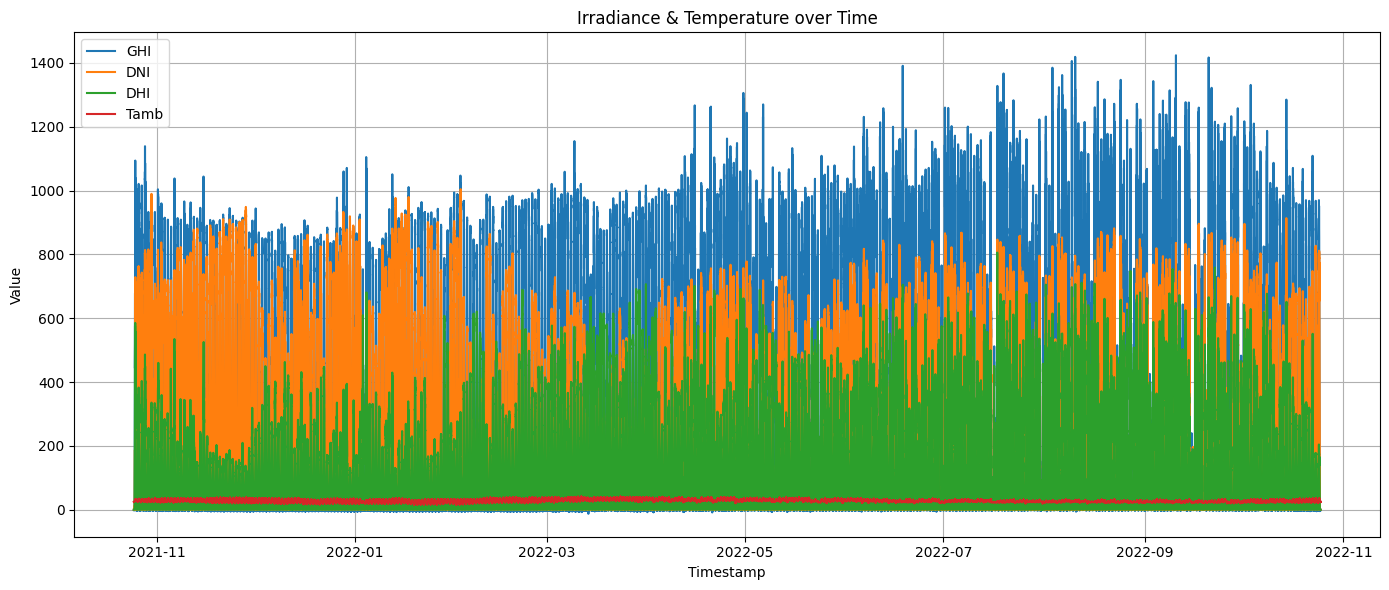

In [21]:


# Set Timestamp as index for easier plotting
df.set_index('Timestamp', inplace=True)

# Select columns to plot
plot_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

# Plot
plt.figure(figsize=(14, 6))
for col in plot_cols:
    plt.plot(df.index, df[col], label=col)

plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Irradiance & Temperature over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_16828\3059238700.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


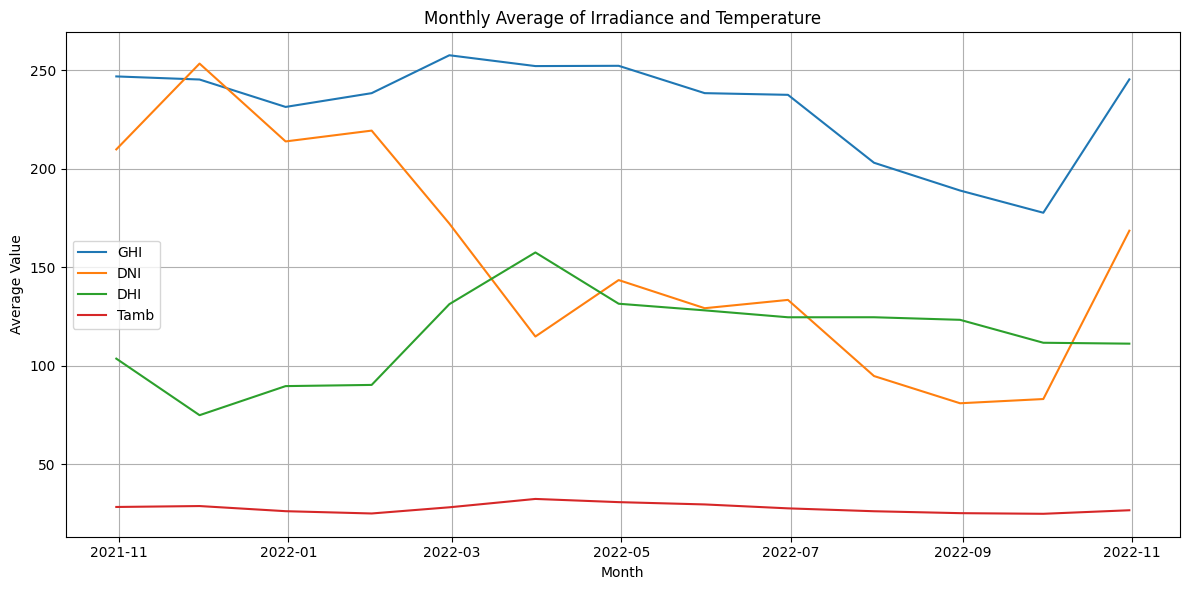

In [22]:
monthly_avg = df.resample('M').mean()

plt.figure(figsize=(12, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(monthly_avg.index, monthly_avg[col], label=col)

plt.title("Monthly Average of Irradiance and Temperature")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


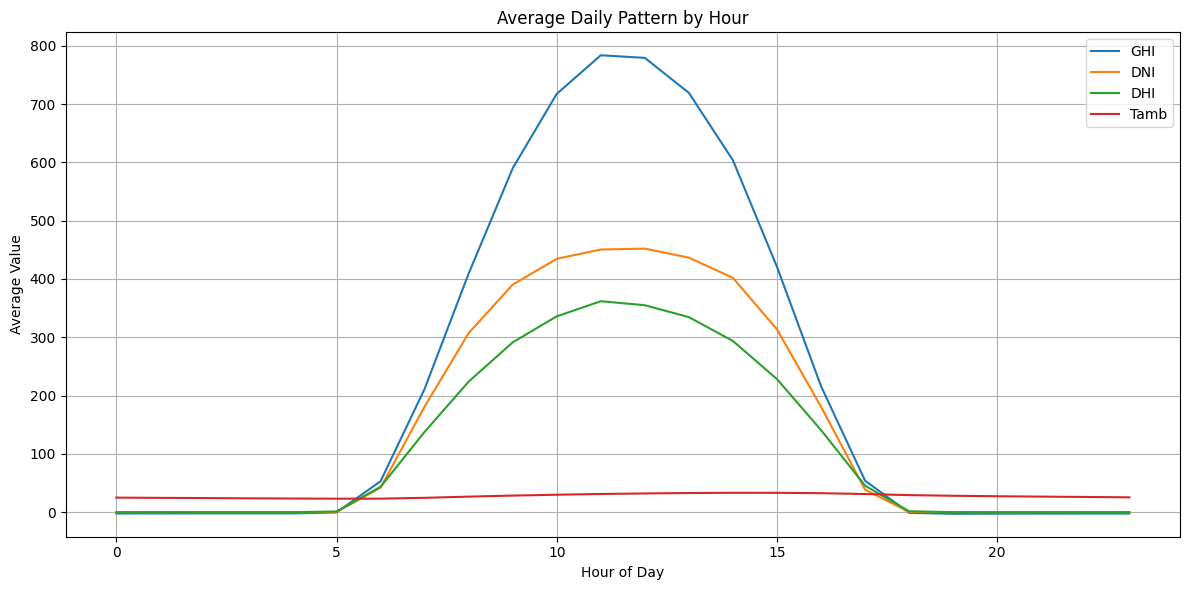

In [23]:
df['Hour'] = df.index.hour
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(hourly_avg.index, hourly_avg[col], label=col)

plt.title("Average Daily Pattern by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
z_scores = df[['GHI', 'DNI', 'DHI', 'Tamb']].apply(zscore)
anomalies = z_scores[(z_scores.abs() > 3).any(axis=1)]

print("Anomalies detected:", anomalies.shape[0])


Anomalies detected: 4714


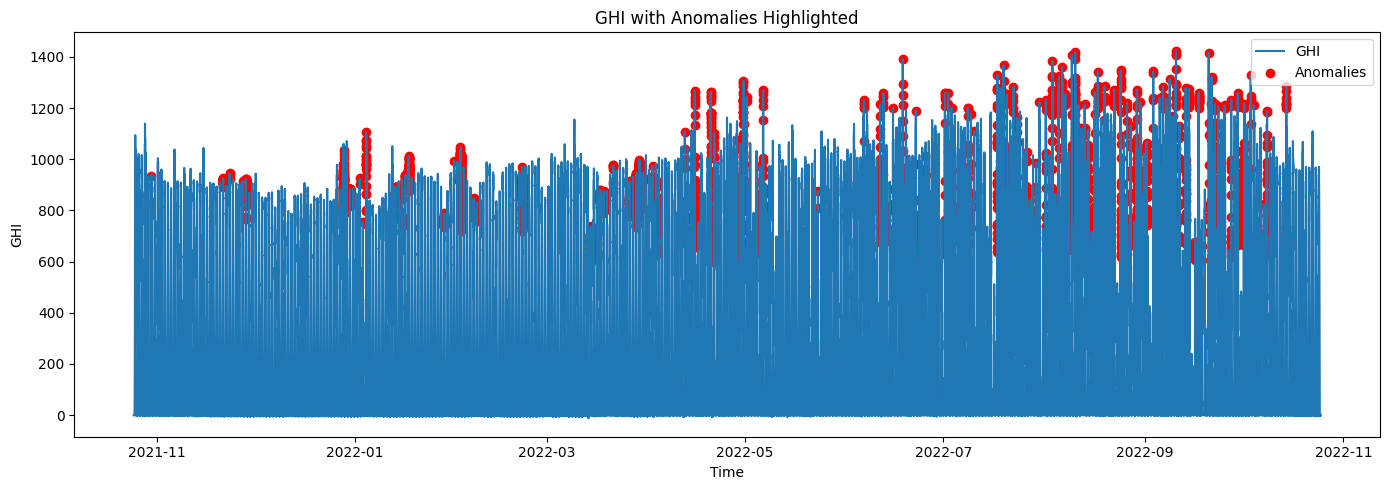

In [25]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['GHI'], label='GHI')
plt.scatter(anomalies.index, df.loc[anomalies.index, 'GHI'], color='red', label='Anomalies')
plt.title("GHI with Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("GHI")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
grouped = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print(grouped)



                ModA        ModB
Cleaning                        
0.0       225.979064  219.401351
1.0       535.186477  532.211744


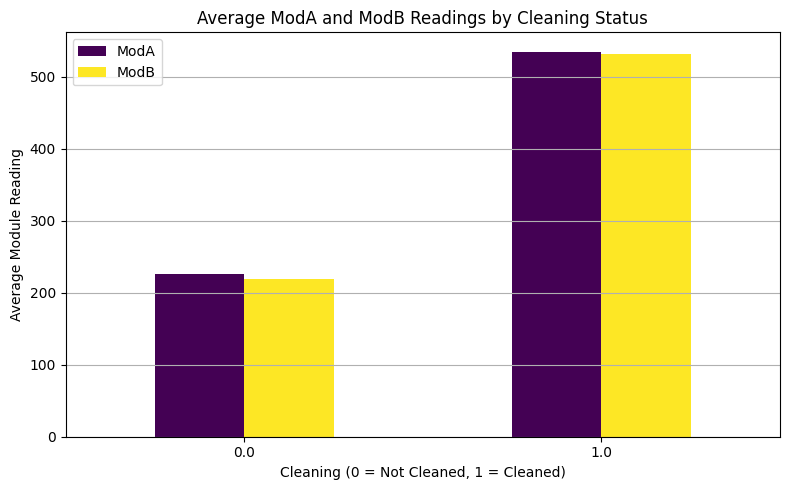

In [27]:
grouped.plot(kind='bar', figsize=(8, 5), colormap='viridis')
plt.title('Average ModA and ModB Readings by Cleaning Status')
plt.xlabel('Cleaning (0 = Not Cleaned, 1 = Cleaned)')
plt.ylabel('Average Module Reading')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [28]:
print(df['Cleaning'].value_counts())



Cleaning
0.0    525319
1.0       281
Name: count, dtype: int64


In [29]:
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']


In [30]:
corr_matrix = df[cols].corr()


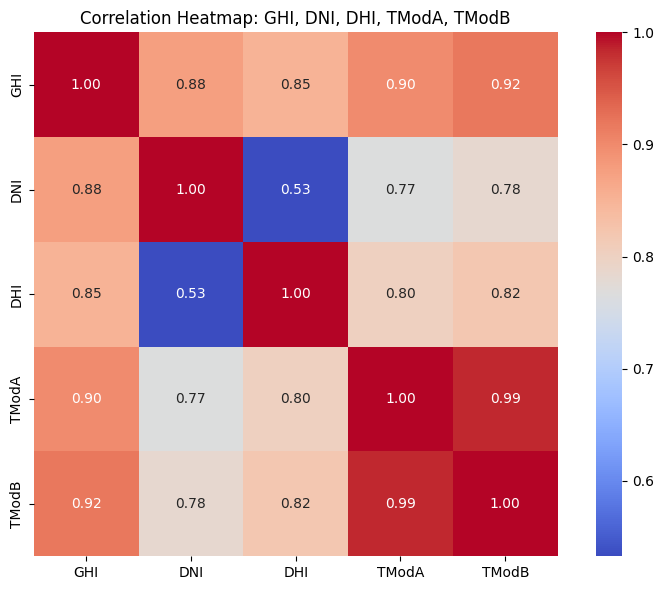

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap: GHI, DNI, DHI, TModA, TModB")
plt.tight_layout()
plt.show()


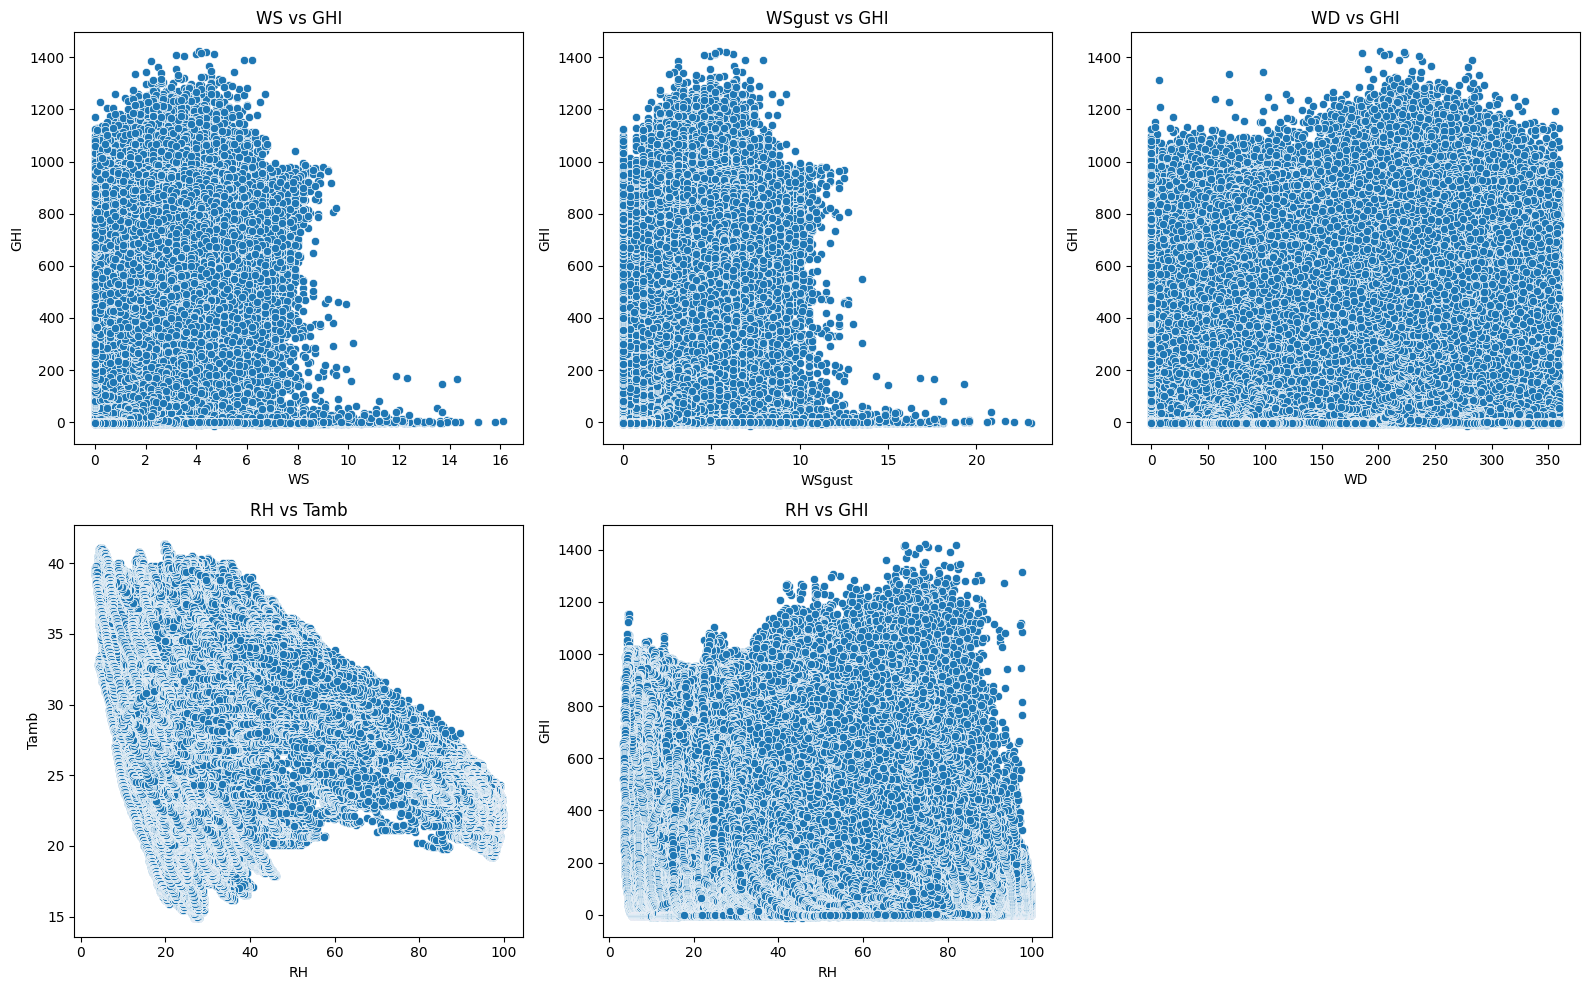

In [32]:
plt.figure(figsize=(16, 10))

# Plot 1: WS vs. GHI
plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x='WS', y='GHI')
plt.title('WS vs GHI')

# Plot 2: WSgust vs. GHI
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='WSgust', y='GHI')
plt.title('WSgust vs GHI')

# Plot 3: WD vs. GHI
plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x='WD', y='GHI')
plt.title('WD vs GHI')

# Plot 4: RH vs. Tamb
plt.subplot(2, 3, 4)
sns.scatterplot(data=df, x='RH', y='Tamb')
plt.title('RH vs Tamb')

# Plot 5: RH vs. GHI
plt.subplot(2, 3, 5)
sns.scatterplot(data=df, x='RH', y='GHI')
plt.title('RH vs GHI')

plt.tight_layout()
plt.show()


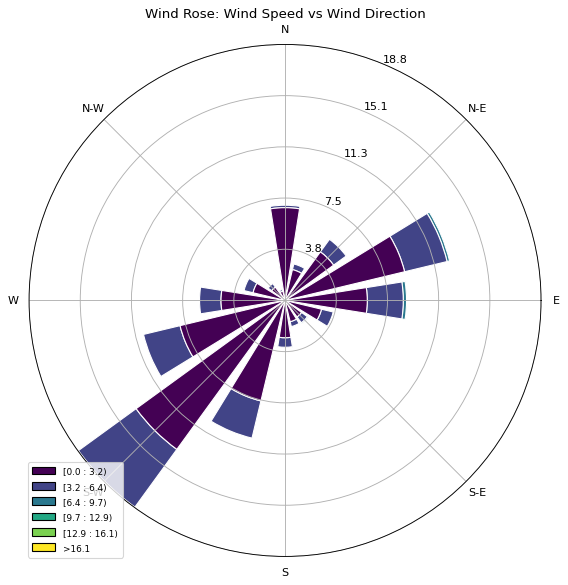

In [33]:
# Convert to numeric (force errors to NaN)
df['WS'] = pd.to_numeric(df['WS'], errors='coerce')
df['WD'] = pd.to_numeric(df['WD'], errors='coerce')

# Drop rows with missing values
wind_data = df[['WS', 'WD']].dropna()

# Create the wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(
    wind_data['WD'], wind_data['WS'],
    normed=True,
    opening=0.8,
    edgecolor='white'
)

# Add legend and title
ax.set_legend()
plt.title('Wind Rose: Wind Speed vs Wind Direction')
plt.show()


In [34]:
# Convert GHI and WS to numeric (in case of bad data)
df['GHI'] = pd.to_numeric(df['GHI'], errors='coerce')
df['WS'] = pd.to_numeric(df['WS'], errors='coerce')


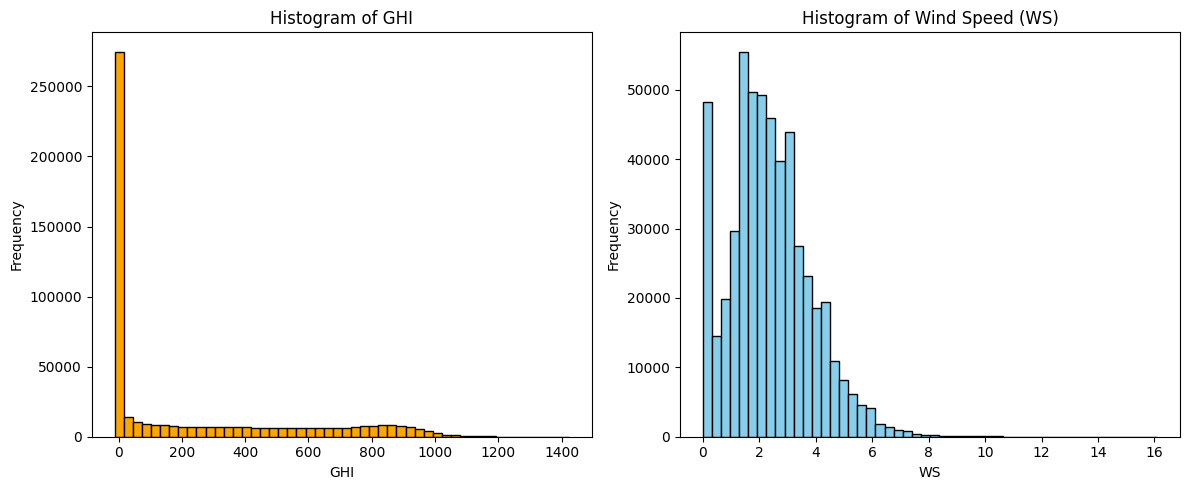

In [35]:
plt.figure(figsize=(12, 5))

# Histogram for GHI
plt.subplot(1, 2, 1)
plt.hist(df['GHI'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title('Histogram of GHI')
plt.xlabel('GHI')
plt.ylabel('Frequency')

# Histogram for WS
plt.subplot(1, 2, 2)
plt.hist(df['WS'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Wind Speed (WS)')
plt.xlabel('WS')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [36]:
# Select relevant columns
columns = ['RH', 'GHI', 'DNI', 'DHI', 'TModA', 'TModB']
df_corr = df[columns].apply(pd.to_numeric, errors='coerce')  # Ensure numeric

# Compute and display correlation matrix
correlation = df_corr.corr()
print(correlation)


             RH       GHI       DNI       DHI     TModA     TModB
RH     1.000000 -0.258077 -0.327887 -0.155016 -0.244825 -0.224668
GHI   -0.258077  1.000000  0.877293  0.852080  0.898211  0.919220
DNI   -0.327887  0.877293  1.000000  0.532717  0.765881  0.783572
DHI   -0.155016  0.852080  0.532717  1.000000  0.802319  0.820360
TModA -0.244825  0.898211  0.765881  0.802319  1.000000  0.985069
TModB -0.224668  0.919220  0.783572  0.820360  0.985069  1.000000


C:\Users\hp\AppData\Local\Temp\ipykernel_16828\4143249747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['RH_bin'] = pd.cut(df_clean['RH'], bins=range(0, 101, 10))
C:\Users\hp\AppData\Local\Temp\ipykernel_16828\4143249747.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_rh = df_clean.groupby('RH_bin')[['GHI', 'TModA']].mean()


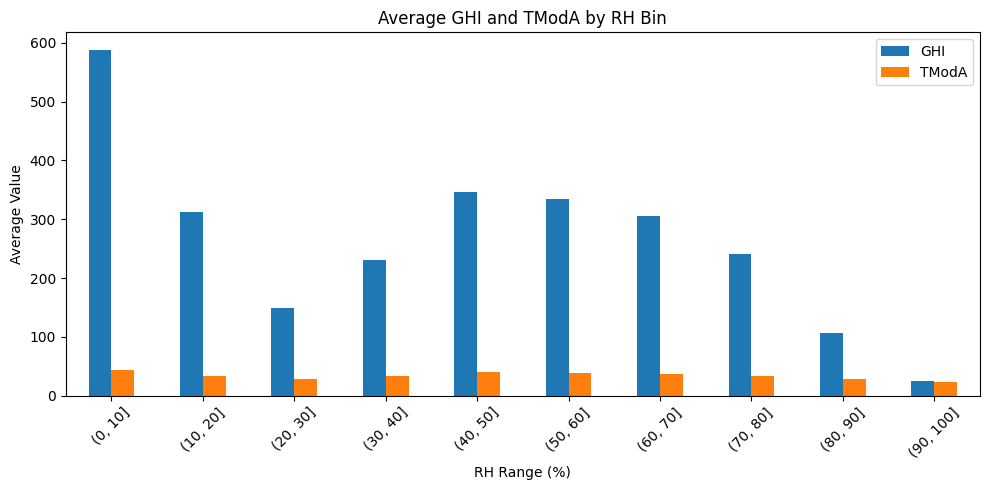

In [37]:
# Make sure RH, GHI, TModA are numeric
df['RH'] = pd.to_numeric(df['RH'], errors='coerce')
df['GHI'] = pd.to_numeric(df['GHI'], errors='coerce')
df['TModA'] = pd.to_numeric(df['TModA'], errors='coerce')

# Drop rows with missing RH (important!)
df_clean = df.dropna(subset=['RH'])

# Bin RH into 10% intervals (e.g., 0-10, 10-20, ...)
df_clean['RH_bin'] = pd.cut(df_clean['RH'], bins=range(0, 101, 10))

# Compute mean GHI and TModA for each RH bin
mean_by_rh = df_clean.groupby('RH_bin')[['GHI', 'TModA']].mean()

# Plotting
mean_by_rh.plot(kind='bar', figsize=(10, 5))
plt.title('Average GHI and TModA by RH Bin')
plt.ylabel('Average Value')
plt.xlabel('RH Range (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


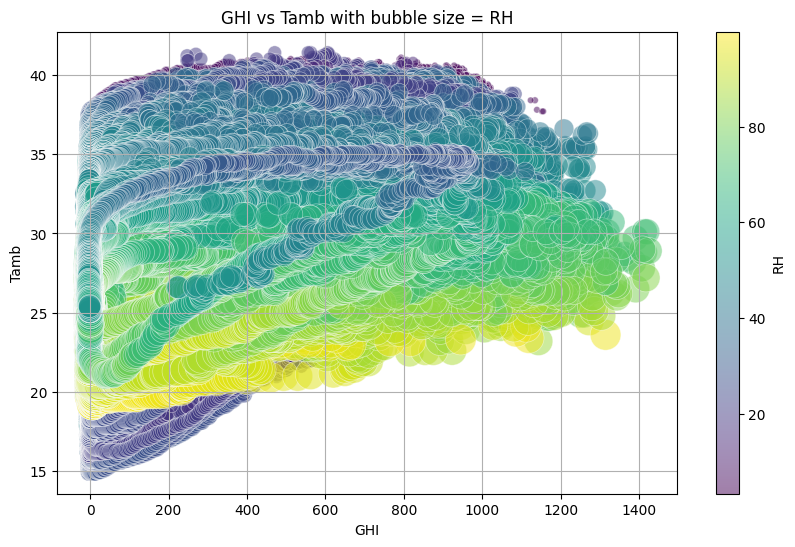

In [38]:
# Make sure these columns are numeric
for col in ['GHI', 'Tamb', 'RH', 'BP']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing data in these columns
df_clean = df.dropna(subset=['GHI', 'Tamb', 'RH', 'BP'])

# Choose the bubble size variable ('RH' or 'BP')
size_var = 'RH'  # or 'BP'

plt.figure(figsize=(10, 6))

# Scatter plot with bubble sizes scaled from the size variable
plt.scatter(
    df_clean['GHI'], 
    df_clean['Tamb'], 
    s=df_clean[size_var] * 5,  # scale bubble size for visibility
    alpha=0.5, 
    c=df_clean[size_var],      # color bubbles by size_var too (optional)
    cmap='viridis',
    edgecolors='w',
    linewidth=0.5
)

plt.colorbar(label=size_var)  # color scale legend
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title(f'GHI vs Tamb with bubble size = {size_var}')
plt.grid(True)
plt.show()
